# Posts Sentiment Analysis
#### on the Palestine-Israel War through Facebook Posts

This notebook explores public sentiment regarding the war between Palestine and Israel by analyzing Facebook posts.

# DATA COLLECTION & ANOTATION
We used a Facebook scraper to collect 1,037 posts from Facebook and manually annotated them.

In [ ]:
!pip install langid

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


import langid


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# load the dataset
df = pd.read_csv('/content/facebook_posts.csv')
df.head()

,post,label
0,"Bella Hadid, though half Palestinian, was born...",against
1,I hate palestines with all of my heart!! 😩😑,against
2,"Hi, I am only recently becoming familiar with ...",neutral
3,Spehar opens the piece with an explanation tha...,neutral
4,NEW YORK RALLY THIS EVENING\nPlease attend thi...,against


# EXPLORATORY DATA ANALYSIS (EDA)

### Basic Info & Describe:

In [ ]:
# basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    1037 non-null   object
 1   label   1033 non-null   object
dtypes: object(2)
memory usage: 16.3+ KB


In [ ]:
# description of the data
df.describe()

,post,label
count,1037,1033
unique,1003,3
top,Happy new month of November 2023. If you love ...,against
freq,9,480


### Duplicate Values:

In [ ]:
# duplicates
df.duplicated().sum()

33

### Dropping Duplicates

In [ ]:
# drop duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

### Unique Labels:

In [ ]:
# unique labels
df['label'].unique()

array(['against', 'neutral', 'with', nan], dtype=object)

*Fact* : Neutral.

*Opinion* : Against/With.

<Axes: xlabel='label', ylabel='count'>

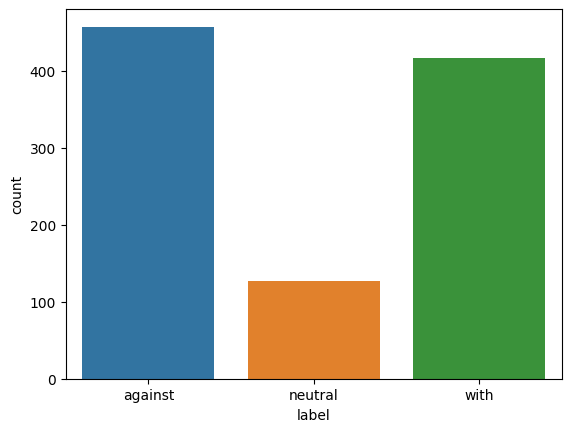

In [ ]:
sns.countplot(x='label', data=df)

### Null Values:

In [ ]:
# Null values
df.isnull().sum()

post     0
label    4
dtype: int64

### Replacing Null values

In [ ]:
df['label'] = df['label'].fillna('neutral')
df.isnull().sum()

post     0
label    0
dtype: int64

### Dtypes:

In [ ]:
# Data Types
df.dtypes

post     object
label    object
dtype: object

### Data Shape

In [ ]:
# DataFrame Shape
df.shape

(1004, 2)

# DATA PREPROCESSING

### Data Cleaning:

In [ ]:
# Lowercasing
df['post'] = df['post'].str.lower()

In [ ]:
# Removing Facebook-Specific Keywords:
df['post'] = df['post'].replace(r'\b(?:like|comment|share)\b', '', regex=True)

# Removing User Mentions:
df['post'] = df['post'].replace(r'@\w+', '', regex=True) #any user mentions in the form of "@username" will be replaced with an empty string.

In [ ]:
# Removing special characters, numbers, and punctuation
df['post'] = df['post'].replace('[^a-zA-Z\s]', '', regex=True)

# Removing Extra Whitespace
df['post'] = df['post'].replace('\s+', ' ', regex=True)

In [ ]:
#  Removing URLs
df['post'] = df['post'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [ ]:
# Identify language
def identify_language(text):
    return langid.classify(text)

# Apply language identification to each post in the DataFrame
df['lang'] = df['post'].apply(identify_language)

# Filter out non-English posts
df = df[df['lang'].apply(lambda x: x[0] == 'en')]

# Drop the 'lang' column (no longer needed)
df = df.drop(columns=['lang'])

In [ ]:
# df after cleaning
df.head()

,post,label
0,bella hadid though half palestinian was born t...,against
1,i hate palestines with all of my heart,against
2,hi i am only recently becoming familiar with t...,neutral
3,spehar opens the piece with an explanation tha...,neutral
4,new york rally this evening please attend this...,against


### Tokenization:

In [ ]:
# tokenizing the posts
df['post'] = df['post'].apply(lambda text: word_tokenize(text))
df.head()

,post,label
0,"[bella, hadid, though, half, palestinian, was,...",against
1,"[i, hate, palestines, with, all, of, my, heart]",against
2,"[hi, i, am, only, recently, becoming, familiar...",neutral
3,"[spehar, opens, the, piece, with, an, explanat...",neutral
4,"[new, york, rally, this, evening, please, atte...",against


### Removing stop words

In [ ]:
# removing the stop words from the posts
stop_words = set(stopwords.words('english'))
df['post'] = df['post'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
df.head()

,post,label
0,"[bella, hadid, though, half, palestinian, born...",against
1,"[hate, palestines, heart]",against
2,"[hi, recently, becoming, familiar, history, co...",neutral
3,"[spehar, opens, piece, explanation, informatio...",neutral
4,"[new, york, rally, evening, please, attend, ra...",against


### Lemmatization

In [ ]:
# lemmatizing the tokens
lemmatizer = WordNetLemmatizer()
df['post'] = df['post'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df.head()

,post,label
0,"[bella, hadid, though, half, palestinian, born...",against
1,"[hate, palestine, heart]",against
2,"[hi, recently, becoming, familiar, history, co...",neutral
3,"[spehar, open, piece, explanation, information...",neutral
4,"[new, york, rally, evening, please, attend, ra...",against


### Encoding Labels

In [ ]:
# removing neutral class
df = df[df['label'] != 'neutral']

# encoding the exsiting classes
label_mapping = {'with': 0, 'against': 1}
df['label'] = df['label'].map(label_mapping)
df.head()

<ipython-input-28-94aaf01a78e9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(label_mapping)


,post,label
0,"[bella, hadid, though, half, palestinian, born...",1
1,"[hate, palestine, heart]",1
4,"[new, york, rally, evening, please, attend, ra...",1
6,"[dead, sea, scroll, discovered, midth, century...",1
7,"[zionism, well, kill, go, gaza, rpe]",0


### Data Splitting:

In [ ]:
# splitting to train and test datasets
X = df['post']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((684,), (171,), (684,), (171,))

### Feature Extraction (Text Vectorization):

In [ ]:
# converting text data into numerical representations using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

X_train = X_train.apply(lambda tokens: ' '.join(tokens)).tolist()
X_test = X_test.apply(lambda tokens: ' '.join(tokens)).tolist()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_train

<684x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 17521 stored elements in Compressed Sparse Row format>

# MODEL TRAINING



### Model 1: Support Vector Machine (Classifier)

In [ ]:
svm = SVC(kernel='rbf', gamma=1, C=1)
svm.fit(X_train, y_train)

SVC(C=1, gamma=1)

### Model 2: Random Forest (Classifier)

In [ ]:
clf = RandomForestClassifier(max_depth = 12, n_estimators = 1000, random_state = 42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=1000, random_state=42)

### Model 3: k-Nearest Neighbors (Classifier)

In [ ]:
knn = KNeighborsClassifier(n_neighbors= 34)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=34)

# MODEL TESTING

### Model 1: Support Vector Machine (Classifier)

In [ ]:
svm_y_pred = svm.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, svm_y_pred))
print('Precision:', precision_score(y_test, svm_y_pred))
print("Recall:", recall_score(y_test, svm_y_pred))
print('F1:', f1_score(y_test, svm_y_pred))
print("\nClassification Report:\n", classification_report(y_test, svm_y_pred))

Accuracy: 0.9064327485380117
Precision: 0.900990099009901
Recall: 0.9381443298969072
F1: 0.9191919191919191

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89        74
           1       0.90      0.94      0.92        97

    accuracy                           0.91       171
   macro avg       0.91      0.90      0.90       171
weighted avg       0.91      0.91      0.91       171



### Model 2: Random Forest (Classifier)

In [ ]:
RF_y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, RF_y_pred))
print('Precision:', precision_score(y_test, RF_y_pred))
print("Recall:", recall_score(y_test, RF_y_pred))
print('F1:', f1_score(y_test, RF_y_pred))
print("\nClassification Report:\n", classification_report(y_test, RF_y_pred, zero_division = 1))

Accuracy: 0.8888888888888888
Precision: 0.8679245283018868
Recall: 0.9484536082474226
F1: 0.9064039408866995

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86        74
           1       0.87      0.95      0.91        97

    accuracy                           0.89       171
   macro avg       0.90      0.88      0.88       171
weighted avg       0.89      0.89      0.89       171



### Model 3: k-Nearest Neighbors (Classifier)

In [ ]:
#predict
kNN_y_pred = knn.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, kNN_y_pred))
print('Precision:', precision_score(y_test, kNN_y_pred))
print("Recall:", recall_score(y_test, kNN_y_pred))
print('F1:', f1_score(y_test, kNN_y_pred))
print("\nClassification Report:\n", classification_report(y_test, kNN_y_pred))

Accuracy: 0.8596491228070176
Precision: 0.8924731182795699
Recall: 0.8556701030927835
F1: 0.8736842105263158

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84        74
           1       0.89      0.86      0.87        97

    accuracy                           0.86       171
   macro avg       0.86      0.86      0.86       171
weighted avg       0.86      0.86      0.86       171



# VISUALIZATION:

###Visualize Cross-Validation to evaluate k-Nearest Neighbors

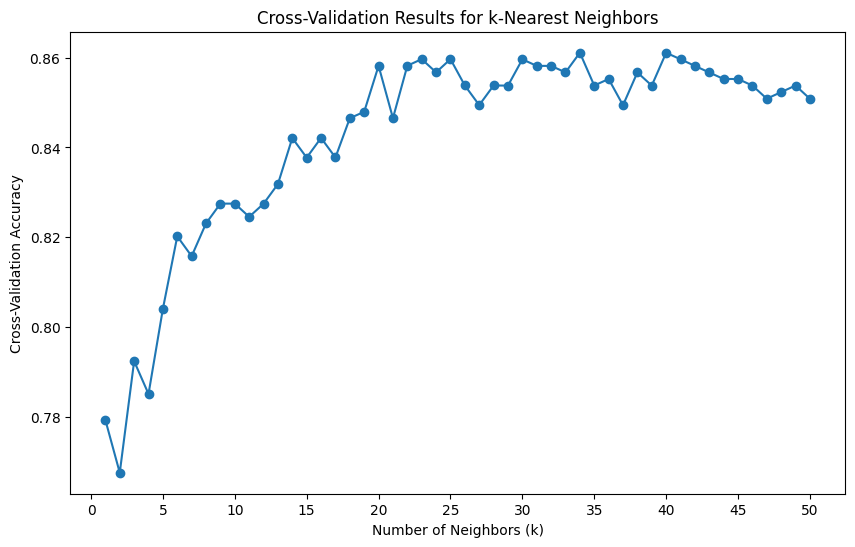

In [ ]:
# Perform cross-validation to evaluate k-Nearest Neighbors
k_values = list(range(1, 51))
cv_results = []

for k in k_values:
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_cv, X_train, y_train, cv=5, scoring='accuracy')
    cv_results.append(scores.mean())

# Visualize cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_results, marker='o')
plt.title('Cross-Validation Results for k-Nearest Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.xticks(np.arange(0, 51, 5))
plt.show()


### Feature Importance for Random Forest


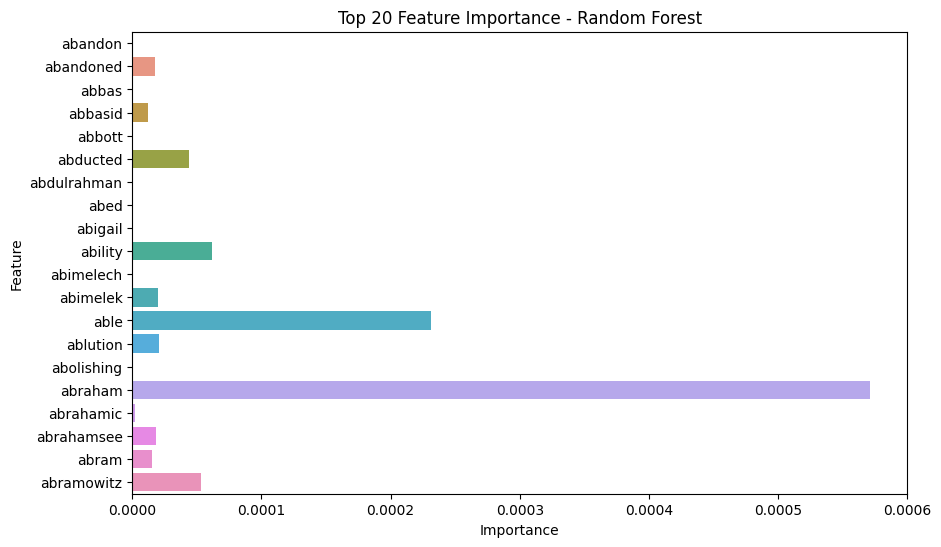

In [ ]:
# feature importance represents the contribution of each word (feature) to the model's decision-making process.
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=clf.feature_importances_[:20], y=feature_names[:20])
plt.title('Top 20 Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


###Confusion Matrix for SVM

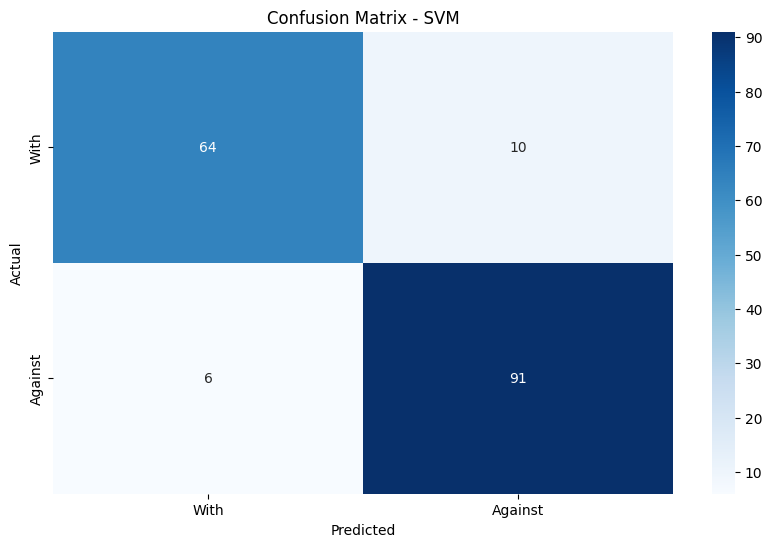

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat_svm = confusion_matrix(y_test, svm_y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['With', 'Against'], yticklabels=['With', 'Against'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



###Confusion Matrix for Random Forest

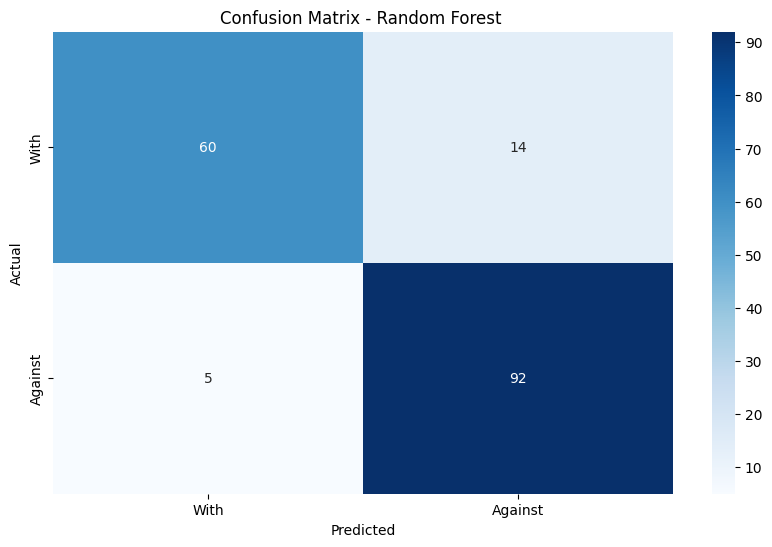

In [ ]:

conf_mat_svm = confusion_matrix(y_test, RF_y_pred )

plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['With', 'Against'], yticklabels=['With', 'Against'])
plt.title('Confusion Matrix - Random Forest ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###Confusion Matrix for k-Nearest Neighbors

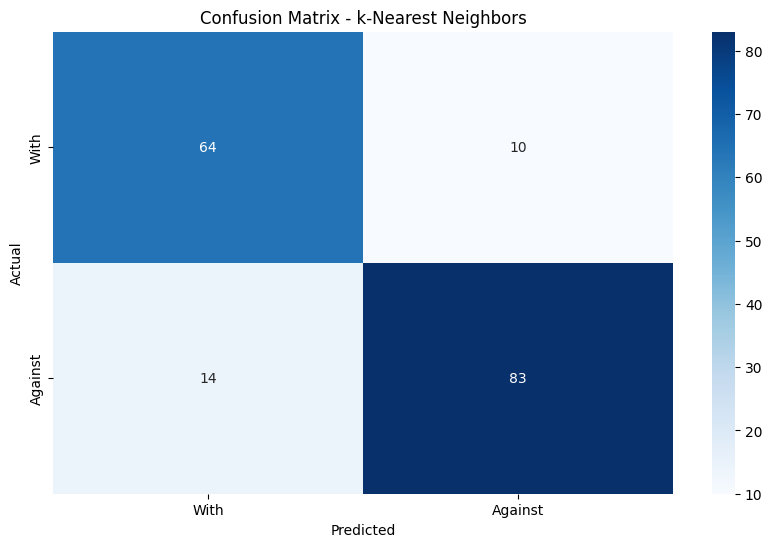

In [ ]:

conf_mat_svm = confusion_matrix(y_test, kNN_y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['With', 'Against'], yticklabels=['With', 'Against'])
plt.title('Confusion Matrix - k-Nearest Neighbors')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


###Model Comparisons

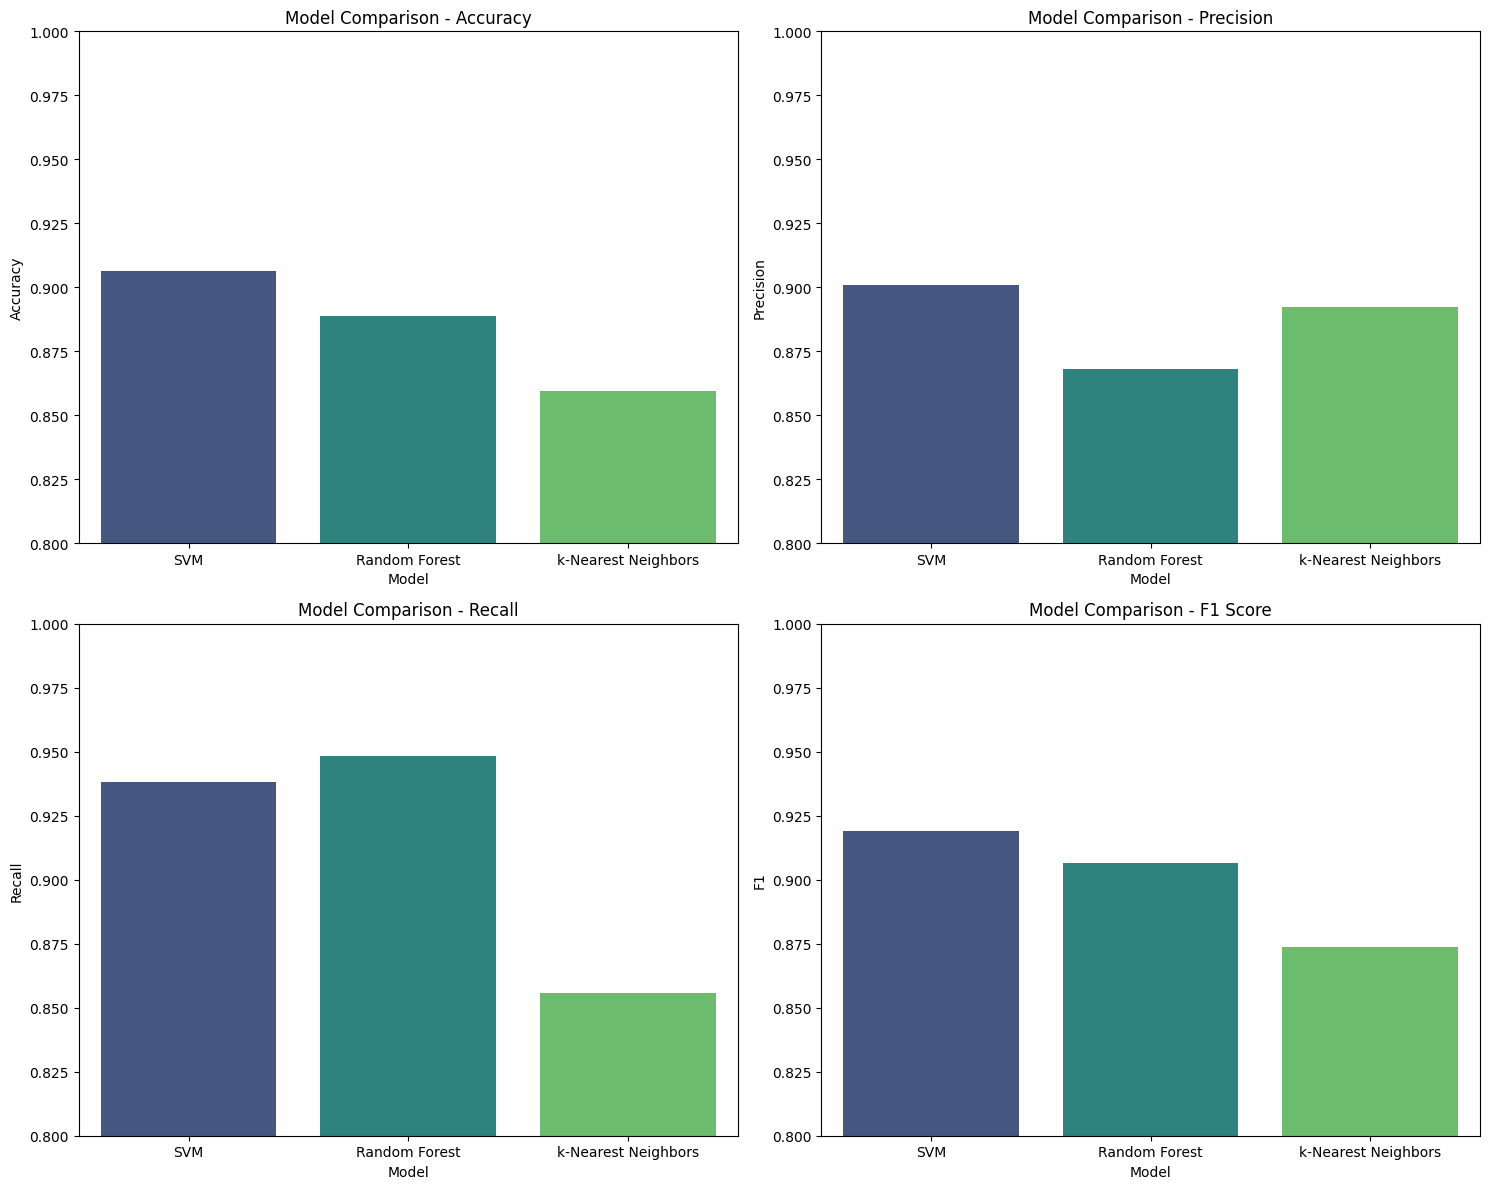

In [ ]:
# Create a DataFrame to compare model performances
model_comparison = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'k-Nearest Neighbors'],
    'Accuracy': [accuracy_score(y_test, svm_y_pred), accuracy_score(y_test, RF_y_pred), accuracy_score(y_test, kNN_y_pred)],
    'Precision': [precision_score(y_test, svm_y_pred), precision_score(y_test, RF_y_pred), precision_score(y_test, kNN_y_pred)],
    'Recall': [recall_score(y_test, svm_y_pred), recall_score(y_test, RF_y_pred), recall_score(y_test, kNN_y_pred)],
    'F1': [f1_score(y_test, svm_y_pred), f1_score(y_test, RF_y_pred), f1_score(y_test, kNN_y_pred)]
})

# Visualize model comparison
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Bar plot for Accuracy
sns.barplot(x='Model', y='Accuracy', data=model_comparison, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Model Comparison - Accuracy')
axes[0, 0].set_ylim(0.8, 1.0)

# Bar plot for Precision
sns.barplot(x='Model', y='Precision', data=model_comparison, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Model Comparison - Precision')
axes[0, 1].set_ylim(0.8, 1.0)

# Bar plot for Recall
sns.barplot(x='Model', y='Recall', data=model_comparison, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Model Comparison - Recall')
axes[1, 0].set_ylim(0.8, 1.0)

# Bar plot for F1 Score
sns.barplot(x='Model', y='F1', data=model_comparison, palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Model Comparison - F1 Score')
axes[1, 1].set_ylim(0.8, 1.0)

plt.tight_layout()
plt.show()


Precision Recall Curve for all models

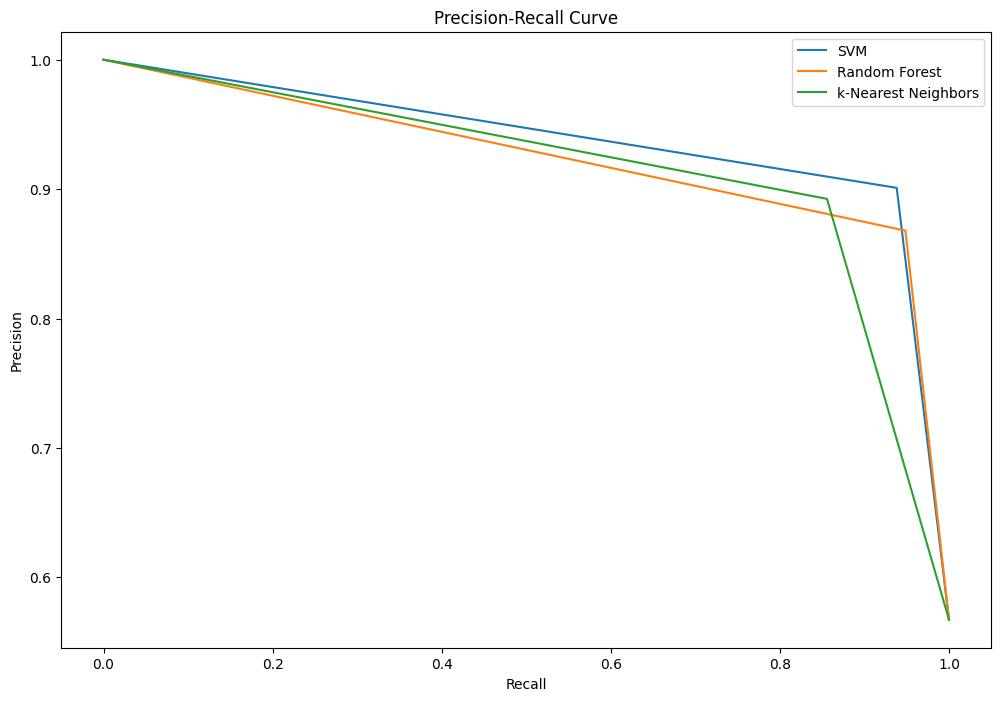

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve for each model
precision_svm, recall_svm, _ = precision_recall_curve(y_test, svm_y_pred)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, RF_y_pred)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, kNN_y_pred)

# Plot precision-recall curves
plt.figure(figsize=(12, 8))
plt.plot(recall_svm, precision_svm, label='SVM')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.plot(recall_knn, precision_knn, label='k-Nearest Neighbors')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
